### This code performs descriptive statistics and dispersion of WOC committs

In [152]:
import pandas as pd
import chardet
import nltk
from nltk.corpus import stopwords
import pickle
import pyarrow.parquet as pq
import numpy
import os
import vaex as vx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import math
import glob
from scipy.optimize import curve_fit
import time

#### Using VAEX dataframes for larger 

In [153]:
# VAEX DATAFRAME
df= []

In [154]:
# READ ALL THE PARQUET FILE
df = vx.open('/data/fdac21/eawoc//processed_data/*.parquet')

In [155]:
# COLUMN NAMES
columns = ["projectID", "commitID", "author", "committer", 
           "authorTime", "committerTime", "authorTimezone", 
           "committerTimezone", "commitMessage"]

In [156]:
# Review the data
df.head()

#,projectID,commitID,author,committer,authorTime,committerTime,authorTimezone,committerTimezone,commitMessage
0,wildfly_wildfly,00001a1a9d1552584eee5e62ab11d7b86408c0d8,ochaloup <ochaloup@redhat.com>,ochaloup <ochaloup@redhat.com>,1488898509,1489149067,+0100,+0100,'[JBTM-2858] adding JAXRS filter to import trans...
1,wildfly_wildfly,00010938ae7227834e2c69a9c3c71c95d3f3483d,Stuart Douglas <stuart.w.douglas@gmail.com>,Stuart Douglas <stuart.w.douglas@gmail.com>,1458105079,1458105079,+1100,+1100,WFCORE-1436 Undertow 1.3.19.Final
2,wildfly_wildfly,000183c08f9e7d9770ad8216acb565552da7bfb0,Jeff Mesnil <jmesnil@gmail.com>,Jeff Mesnil <jmesnil@gmail.com>,1332344580,1332436142,+0100,+0100,'[JBPAPP-8184] Connection factory failure\\n* add...
3,wildfly_wildfly,0001a3f7a195b75e563280609636faa249877036,jaikiran <jaikiran.pai@gmail.com>,baranowb <baranowb@gmail.com>,1328294482,1328611298,+0530,+0100,Upgrade to 2.0.0 of jboss-ejb3-ext-api
4,wildfly_wildfly,00024ccfa6fa6fd6426de7bb1d8d494798b384fe,James R. Perkins <jperkins@redhat.com>,GitHub <noreply@github.com>,1583899415,1583899415,-0700,-0700,'Merge pull request #13102 from kabir/WFLY-13222...
5,wildfly_wildfly,0002dbdc7b6cb98e6387cc5f0d11bb93229c5381,Kabir Khan <kkhan@redhat.com>,GitHub <noreply@github.com>,1491037874,1491037874,+0100,+0100,'Merge pull request #9883 from jbosstm/WFLY-8485...
6,wildfly_wildfly,000325d9bb03ceffbe9e7b4756a5566b273040d1,Brian Stansberry <brian.stansberry@redhat.com>,Brian Stansberry <brian.stansberry@redhat.com>,1503172204,1505862581,-0500,-0500,Minor cleanup
7,wildfly_wildfly,0003c4792f52061661cc9db421c7741bc4df8284,Richard Achmatowicz <rachmatowicz@jboss.com>,Paul Ferraro <paul.ferraro@redhat.com>,1370975878,1374591017,-0400,-0400,"[WFLY-1430] Add in XML processing, test cases."
8,wildfly_wildfly,0004ba7ca70b15a48fe6460ec5375c86cd8dc19d,Scott Marlow <smarlow@redhat.com>,Scott Marlow <smarlow@redhat.com>,1463689533,1473273893,-0400,-0400,'add org.wildfly.extension.nosql.common dependen...
9,wildfly_wildfly,000703aae4a2cc2cc0f1c4a9a03ae391bb76def0,Pelisse Romain <belaran@redhat.com>,GitHub <noreply@github.com>,1470623929,1470623929,+0000,+0000,'Merge 03a1e02b4aa392ec3d8914846eee615232f45d89 ...


In [157]:
# Generate value count for project name and number of commits made in it. (takes time)
px = pd.DataFrame(df.projectID.value_counts())

In [162]:
# assign the elements
proj_commits=px[0]
proj_commits.describe()

count    1.161000e+03
mean     4.155006e+05
std      1.252033e+06
min      2.000000e+00
25%      1.247850e+05
50%      1.778800e+05
75%      3.329680e+05
max      3.133212e+07
Name: 0, dtype: float64

### [1] Perform descriptive statistics to understand the basic features of the commit messages in WoC[1]. In  particular, we will gather fundamental insights of WoC by calculating the measures of central tendencies and the dispersion of the commit messages in the WoC.

In [159]:
# Function to calculate measures of Central Tendencies - Mean, Mode, Median and dispersion values of a repository
def descriptive_statics(project_name, total_commits, val):
    print("--------------------------------")
    print("Average number of commits per repository:" + str(st.mean(val)))
    print("Most common number of commits per repository:" + str(st.mode(val)))
    print("Median number of commits per repository:" + str(st.median(val)))
    print("Harmonic mean of commits per repository:" + str(st.harmonic_mean(val)))
    print("********* DISPERSION *********")
    print("Variance in the number of commit messages:" + str(st.variance(val)))
    print("Population Variance in the number of commit messages:" + str(st.pvariance(val)))
    print("Standard Deviation in the number of commit messages:" + str(st.stdev(val)))
    print("Population Standard Deviation in the number of commit messages:" + str(st.pstdev(val)))
    print("--------------------------------")
    result = {'project_name': project_name,
              'total_commits': total_commits,
              'Mean': st.mean(val), 
              'Mode': st.mode(val), 
              'Median': st.median(val), 
              'harmonic_mean': st.harmonic_mean(val),
              'variance': st.variance(val),
              'p_variance': st.pvariance(val),
              'stdev': st.stdev(val),
              'p_stdev': st.pstdev(val)}
    return result
    

In [160]:
# function for plotting descriptive statistics and dispersion results (need improvements)
def plot_stats(stats):
    fig, axes = plt.subplots(3, 3, figsize=(18, 10))


    plt.subplots_adjust(hspace = .5)

    fig.suptitle('Discriptive Statistics and Dispersion')


    ax = sns.scatterplot(data=stats['total_commits'], ax=axes[0, 0])
    ax.set(xlabel='Project', ylabel='Total Commits', title='Total Commits')

    ax = sns.scatterplot(data=stats['Mean'], ax=axes[0, 1])
    ax.set(xlabel='Project', ylabel='Mean', title='Mean')

    ax = sns.scatterplot(data=stats['Mode'], ax=axes[0, 2])
    ax.set(xlabel='Project', ylabel='Mode', title='Mode')

    ax = sns.scatterplot(data=stats['Median'], ax=axes[1, 0])
    ax.set(xlabel='Project', ylabel='Median', title='Median')

    ax = sns.scatterplot(data=stats['harmonic_mean'], ax=axes[1, 1])
    ax.set(xlabel='Project', ylabel='harmonic_mean', title='Harmonic Mean')

    ax = sns.scatterplot(data=stats['variance'], ax=axes[1, 2])
    ax.set(xlabel='Project', ylabel='variance', title='Variance')

    ax = sns.scatterplot(data=stats['p_variance'], ax=axes[2, 0])
    ax.set(xlabel='Project', ylabel='p_variance', title='Population Variance')

    ax = sns.scatterplot(data=stats['stdev'], ax=axes[2, 1])
    ax.set(xlabel='Project', ylabel='stdev', title='Standard Deviation')

    ax = sns.scatterplot(data=stats['p_stdev'], ax=axes[2, 2])
    ax.set(xlabel='Project', ylabel='p_stdev', title='Population Standard Deviation')

    plt.savefig("stats-" + str(time.time()) + '.png')

Text(0, 0.5, '# of commits')

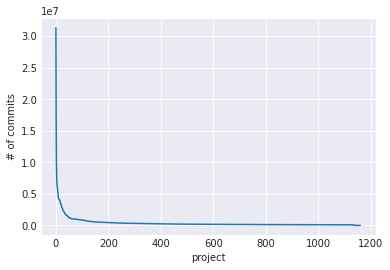

In [163]:
# some exploratory statistics. plot all the committ messages per project

sns.set_style('darkgrid')
p=sns.lineplot(data=proj_commits.values)
p.set_xlabel('project')
p.set_ylabel('# of commits')

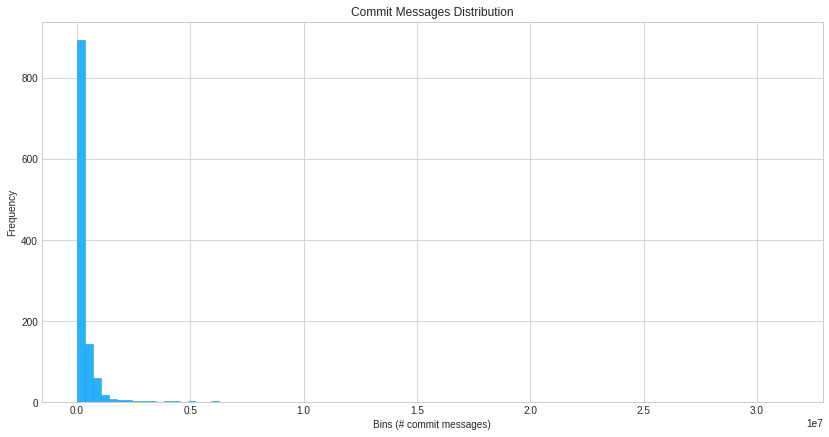

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


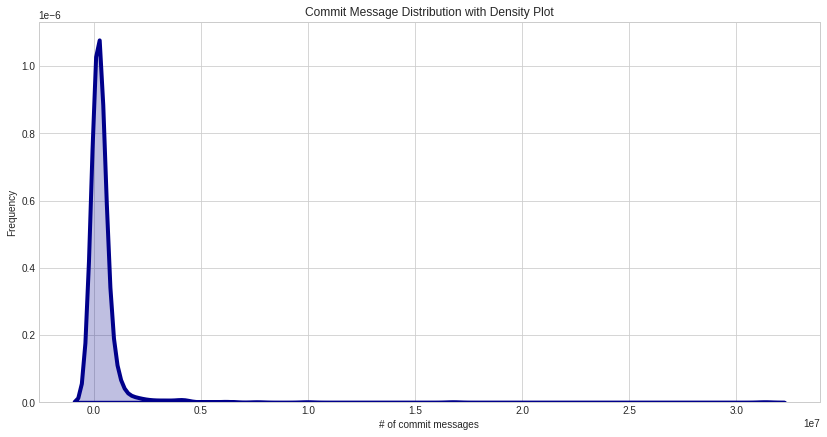

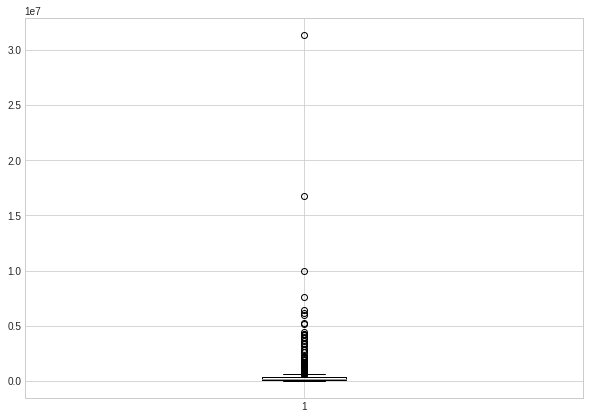

In [164]:
# HISTOGRAM, DENSITY PLOT, ETC OF ALL THE MESSAE COMBINED. 

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(proj_commits.values, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Commit Messages Distribution') 
plt.xlabel('Bins (# commit messages)') 
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize=(14,7)) # Make it 14x7 inch

sns.distplot(proj_commits.values, hist=False, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade': True})
plt.legend()
plt.xlabel('# of commit messages')
plt.ylabel('Frequency')
plt.title('Commit Message Distribution with Density Plot')

fig = plt.figure(figsize=(10,7))
plt.boxplot(proj_commits.values)
plt.savefig('ao.png')
plt.show()


In [165]:
# AGGREGATE STATS. DESCRIPTIVE STATS AND DISPERSION
print(sum(proj_commits.values))
result = descriptive_statics('All Projects', sum(proj_commits.values), proj_commits.values)
print(result)
res = pd.DataFrame()
res = res.append(result, ignore_index = True)

482396158
--------------------------------
Average number of commits per repository:415500
Most common number of commits per repository:8
Median number of commits per repository:177880
Harmonic mean of commits per repository:253.16290170617083
********* DISPERSION *********
Variance in the number of commit messages:1567587572186
Population Variance in the number of commit messages:1566237367559
Standard Deviation in the number of commit messages:1252033.375028797
Population Standard Deviation in the number of commit messages:1251494.0541444854
--------------------------------
{'project_name': 'All Projects', 'total_commits': 482396158, 'Mean': 415500, 'Mode': 8, 'Median': 177880, 'harmonic_mean': 253.16290170617083, 'variance': 1567587572186, 'p_variance': 1566237367559, 'stdev': 1252033.375028797, 'p_stdev': 1251494.0541444854}


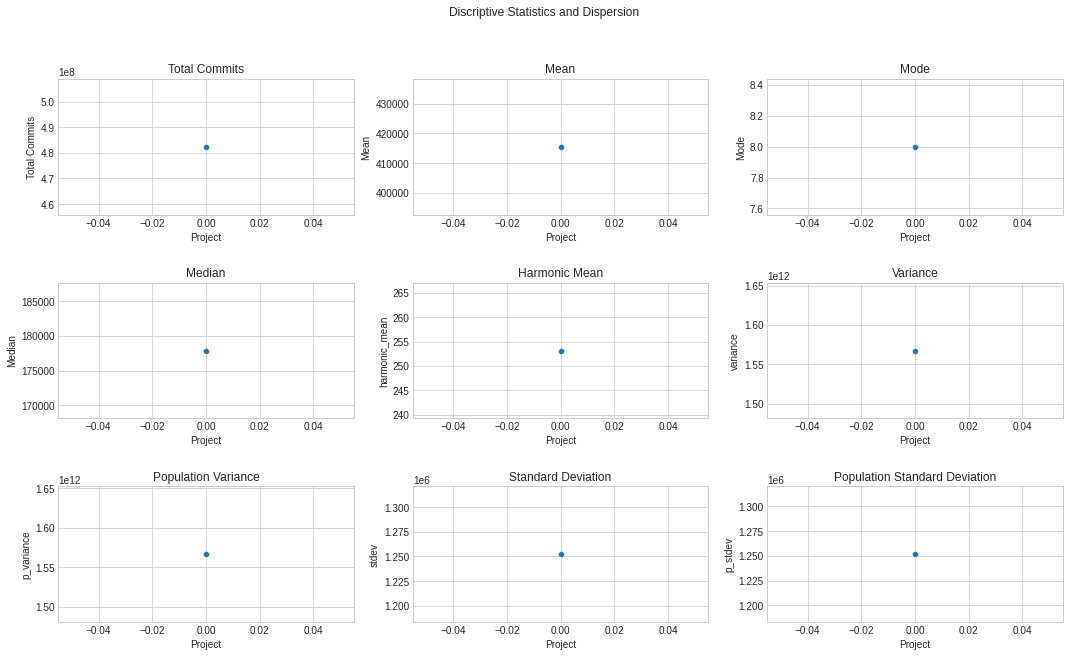

In [166]:
# PLOT AGGREGATE STATS. 
plot_stats(res)

#### SELECT RANDOM 1000 PROJECT AND PERFORM DESCRIPTIVE STATS AND DISPERSION

In [167]:
# DESCRIPTIVE STATS FOR 50-1000 RANDOME SAMPLE. (TAKE TIME, TRY DOING PARALLELIZATION) . currently done for sample size = 3. 
ss = proj_commits.sample(n=3)
#print(ss)
stats = pd.DataFrame()
for project, commits in ss.items():
    print('-->',project, '|',  commits)
    project_record =  df[df['projectID'] == project]
    #print(project_record.head(n=2))
    
    pp=project_record['committer'].value_counts()
    val = pp.values
    try:
        result = descriptive_statics(project, commits, val)
        stats = stats.append(result, ignore_index = True)
    except:
        print('some error!')
    print(stats)
    #dispersion_statistics(pp.values)
print(stats)

--> alrieckert_lazarus | 253180
--------------------------------
Average number of commits per repository:2182
Most common number of commits per repository:1
Median number of commits per repository:120.0
Harmonic mean of commits per repository:5.233890427318034
********* DISPERSION *********
Variance in the number of commit messages:49175216
Population Variance in the number of commit messages:48751292
Standard Deviation in the number of commit messages:7012.50426024826
Population Standard Deviation in the number of commit messages:6982.212543313187
--------------------------------
         project_name  total_commits    Mean  Mode  Median  harmonic_mean  \
0  alrieckert_lazarus       253180.0  2182.0   1.0   120.0        5.23389   

     variance  p_variance       stdev      p_stdev  
0  49175216.0  48751292.0  7012.50426  6982.212543  
--> fikrado_go- | 104977
--------------------------------
Average number of commits per repository:52488
Most common number of commits per repository:

Task exception was never retrieved
future: <Task finished name='Task-217' coro=<DataFrame.execute_async() done, defined at /home/amalviya/.local/lib/python3.8/site-packages/vaex/dataframe.py:400> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_36095/3857623107.py", line 10, in <module>
    pp=project_record['committer'].value_counts()
  File "/home/amalviya/.local/lib/python3.8/site-packages/vaex/expression.py", line 995, in value_counts
    self.ds.map_reduce(map, reduce, [self.expression], delay=False, progress=progress, name='value_counts', info=True, to_numpy=False)
  File "/home/amalviya/.local/lib/python3.8/site-packages/vaex/dataframe.py", line 415, in map_reduce
    return self._delay(delay, task)
  File "/home/amalviya/.local/lib/python3.8/site-packages/vaex/dataframe.py", line 15

--------------------------------
Average number of commits per repository:2098
Most common number of commits per repository:1
Median number of commits per repository:1
Harmonic mean of commits per repository:1.431103130744189
********* DISPERSION *********
Variance in the number of commit messages:1093757174
Population Variance in the number of commit messages:1089364575
Standard Deviation in the number of commit messages:33071.99984881471
Population Standard Deviation in the number of commit messages:33005.5234013945
--------------------------------
         project_name  total_commits     Mean      Mode   Median  \
0  alrieckert_lazarus       253180.0   2182.0       1.0    120.0   
1         fikrado_go-       104977.0  52488.0  104976.0  52488.5   
2   mquinson_PLM-data       522527.0   2098.0       1.0      1.0   

   harmonic_mean      variance    p_variance         stdev       p_stdev  
0       5.233890  4.917522e+07  4.875129e+07   7012.504260   6982.212543  
1       1.999981  5.

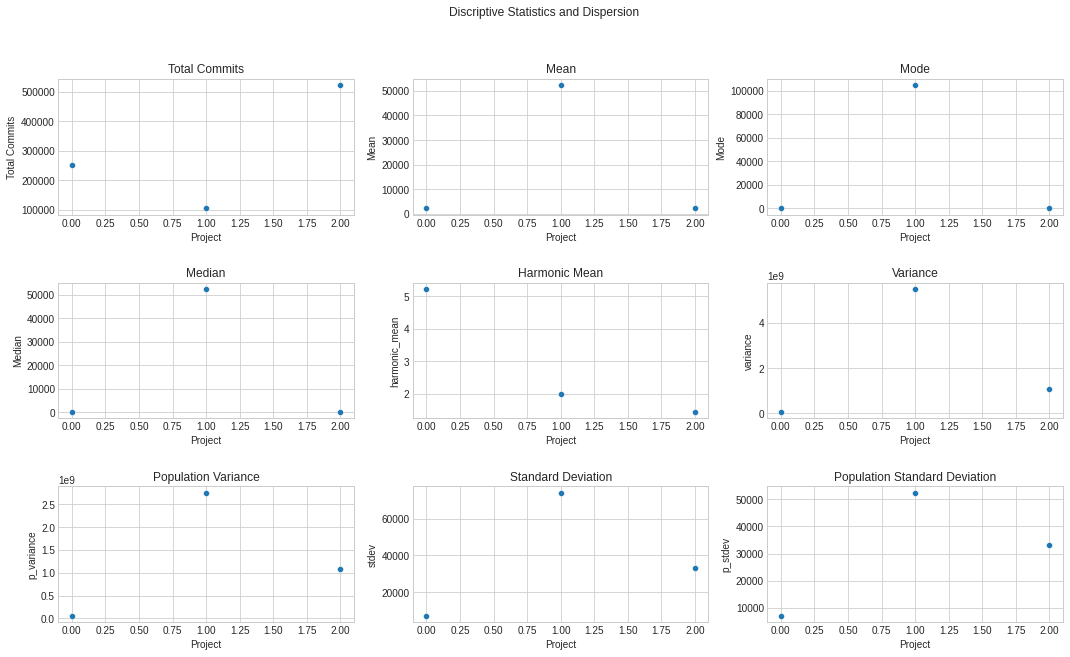

In [168]:
plot_stats(stats)

### [2] Term frequency extraction and analysis to discover the most common words used in the commit messages

### [3] Plot the temporal distribution of first and last 10,000 commit messages of random 1000 projects with at least 50,000 commits. Also, perform distribution fitting to finding the best distribution that fits the underlying commit messages at each repository level.

### [4] Hypothesis testing for the presence or absence of Pareto Principle for the number of commits made by the software developers. Specifically, we will study if 80% of commit message come from 20% of committers for a random sample of 100,000 repositories (at each repository level).

In [ ]:
# We start by evaluating if the number of commits in the list of project fit pareto distribution (power law distribution)

import powerlaw
data = proj_commits.values # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print (R, p, results)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
figPDF = results.plot_pdf( color= 'r', )
figPDF.set_xlabel("# of commits")
figPDF.set_ylabel("p(X)")

In [ ]:
pp=proj['committer'].value_counts()

In [ ]:
print(pp.values)

In [ ]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(pp.values, bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Commit Messages Distribution Per Project') 
plt.xlabel('Bins (# commit messages)') 
plt.ylabel('Frequency') 
plt.show()

In [ ]:
print(pp.values)
#plt.plot(pp.values)
data = pp.values # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print (R, p)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
figPDF = results.plot_pdf( color= 'r', )
figPDF.set_xlabel("# of commits")
figPDF.set_ylabel("p(X)")

### [5] Develop static and interactive visualizations to demonstrate the findings.